# คาดการณ์การวินิจฉัยผู้ป่วยโรคเบาหวาน

#### Pregnancies = จำนวนครั้งที่ตั้งครรภ์
#### Glucose = ความเข้มข้นของกลูโคสในพลาสมา 2 ชั่วโมงในการทดสอบความทนทานต่อกลูโคสในช่องปาก
#### BloodPressure = ความดันโลหิต Diastolic (มม. ปรอท)
#### SkinThickness = ความหนาของผิว
#### Insulin = เซรั่มอินซูลิน 2 ชั่วโมงในการทดสอบ (mu U/ml)
#### BMI = ค่าดัชนีมวลกาย
#### DiabetesPedigreeFunction = สายเลือดเบาหวาน
#### Age = อายุ 
#### Outcome = ผล 0 : ไม่เป็น , 1 : เป็น

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier  
from sklearn.linear_model import LogisticRegression , SGDClassifier
from sklearn.naive_bayes import MultinomialNB , GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier , RandomForestClassifier , AdaBoostClassifier , ExtraTreesClassifier , GradientBoostingClassifier 

from sklearn.feature_selection import RFECV , RFE
from sklearn.preprocessing import RobustScaler , StandardScaler
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV , train_test_split , cross_val_score , cross_val_predict
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE , RandomOverSampler
from sklearn.pipeline import Pipeline


In [3]:
pima = pd.read_csv('diabetes.csv')
pima.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
pima.rename(columns={'DiabetesPedigreeFunction' : 'DPF'} , inplace=True)

## Data Understanding

ตรวจสอบข้อมูลเบื้องต้น

In [5]:
pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pregnancies    768 non-null    int64  
 1   Glucose        768 non-null    int64  
 2   BloodPressure  768 non-null    int64  
 3   SkinThickness  768 non-null    int64  
 4   Insulin        768 non-null    int64  
 5   BMI            768 non-null    float64
 6   DPF            768 non-null    float64
 7   Age            768 non-null    int64  
 8   Outcome        768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


#### ตรวจสอบข้อมูลตัวเลข

In [6]:
pima.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DPF,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


#### เปลี่ยนค่าที่เป็น 0 เป็นค่า mean

In [7]:
def zero_to_mean(col):
    pima[col] = pima[col].map(lambda x : pima[col].mean() if x == 0 else x)

In [8]:
for i in pima.columns:
    if i not in 'Outcome' :
        zero_to_mean(i)

In [9]:
pima.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,4.400782,2.984162,1.000,2.000000,3.845052,6.00000,17.00
Glucose,768.0,121.681605,30.436016,44.000,99.750000,117.000000,140.25000,199.00
BloodPressure,768.0,72.254807,12.115932,24.000,64.000000,72.000000,80.00000,122.00
SkinThickness,768.0,26.606479,9.631241,7.000,20.536458,23.000000,32.00000,99.00
Insulin,768.0,118.660163,93.080358,14.000,79.799479,79.799479,127.25000,846.00
BMI,768.0,32.450805,6.875374,18.200,27.500000,32.000000,36.60000,67.10
DPF,768.0,0.471876,0.331329,0.078,0.243750,0.372500,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.000000,29.000000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.000000,0.000000,1.00000,1.00


## EDA

In [10]:
plt.style.use('bmh')

In [11]:
def hist_box_plot(col) :

    fig , ax = plt.subplots(1,2 , figsize=(8,3))
    sns.histplot(pima[col] , ax=ax[0] , bins=20 )
    sns.boxplot(pima[col] , ax=ax[1])
    
    plt.tight_layout()

#### การกระจายตัวของข้อมูลในคุณสมบัติต่างๆ

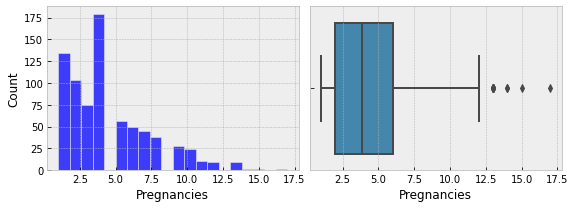

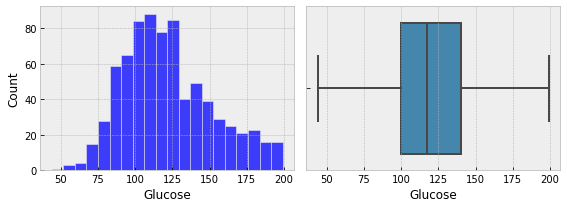

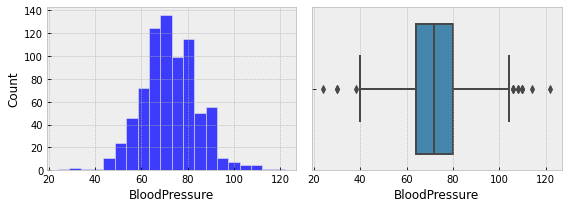

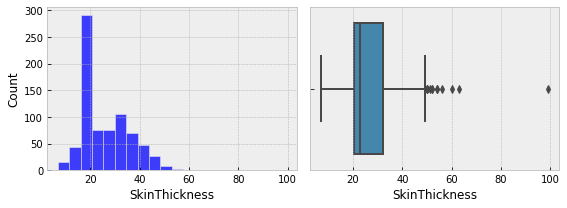

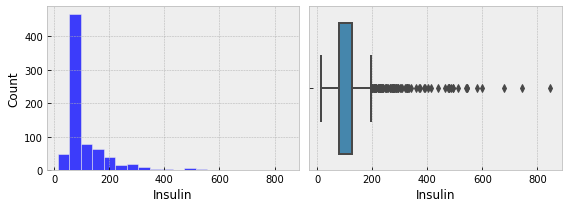

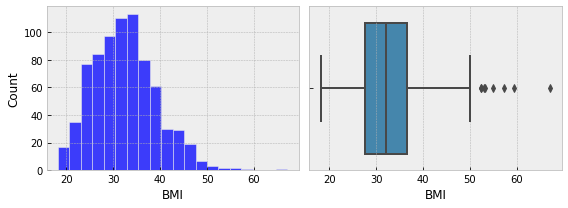

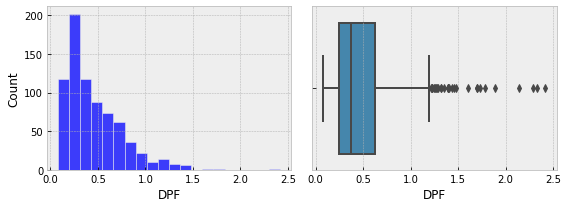

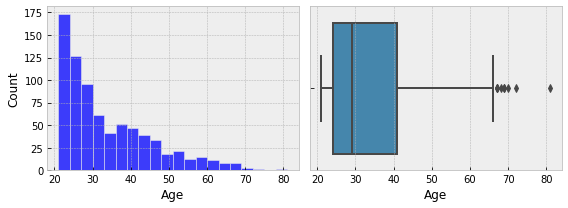

In [12]:
for  col in pima.columns:
    if col not in 'Outcome' :    
        hist_box_plot(col)

#### จำนวน Outcome ระหว่างคนที่ไม่เป็นเบาหวาน(0) และ คนที่เป็นเบาหวาน(1)

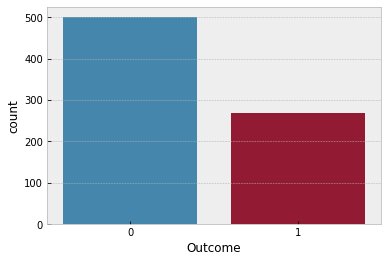

In [13]:
sns.countplot(pima['Outcome']);

In [14]:
def hist_box_plot_hue(col) :

    fig , ax = plt.subplots(1,2 , figsize=(8,3))
    sns.histplot(data=pima , x=col , hue='Outcome' , ax=ax[0] , bins=20 )
    sns.boxplot(data=pima , x=col , y='Outcome',orient="h", ax=ax[1])
    
    plt.tight_layout()

#### การกระจายตัวของข้อมูลในคุณสมบัติต่างๆ ระหว่างคนที่ไม่เป็นเบาหวาน(0) และ คนที่เป็นเบาหวาน(1)

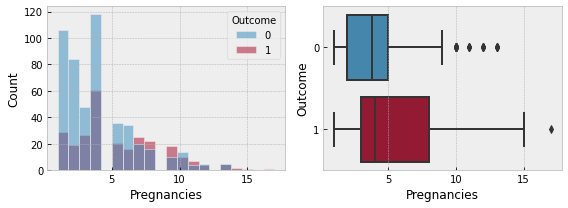

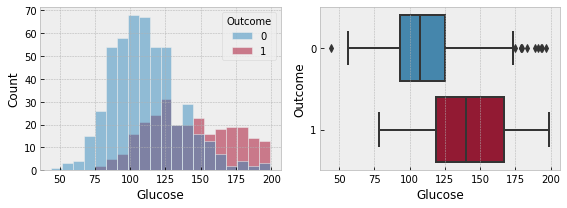

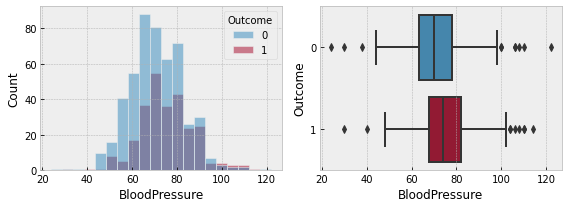

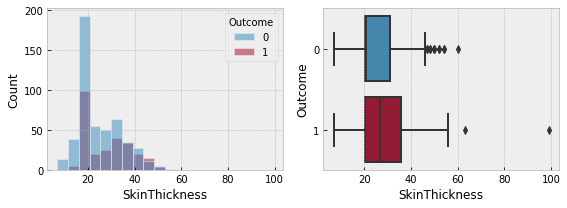

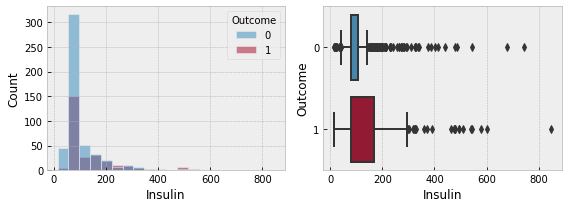

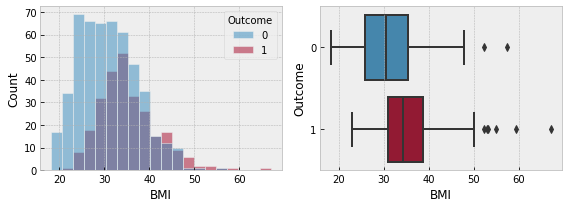

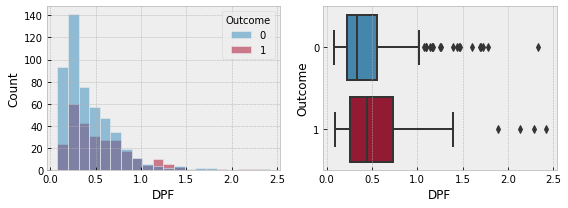

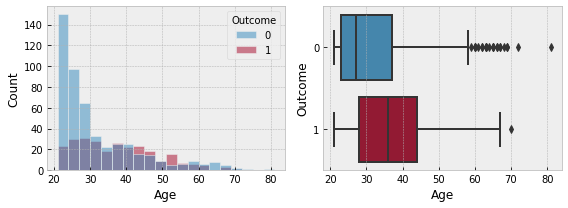

In [15]:
for  col in pima.columns:
    if col not in 'Outcome' :    
        hist_box_plot_hue(col)

#### ความสัมพันธ์ระหว่างคุณสมบัติ

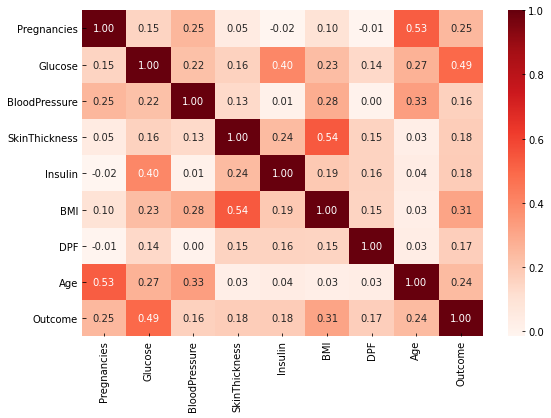

In [16]:
plt.figure(figsize=(9,6))
sns.heatmap(pima.corr() , annot=True , fmt='.2f' , cmap='Reds');

#### ความสัมพันธ์ระหว่าง Age(อายุ) กับ BMI(ดัชนีมวลกาย)

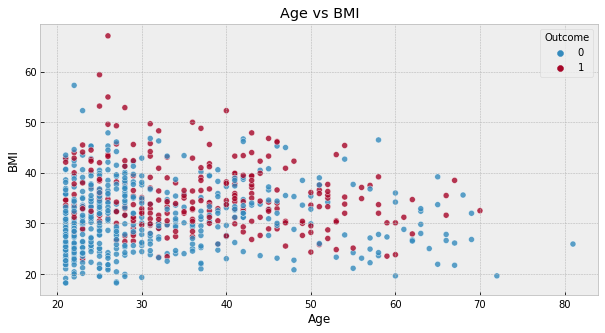

In [17]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=pima , x='Age' , y='BMI' , hue='Outcome' , alpha=0.8)
plt.title('Age vs BMI');

#### ความสัมพันธ์ระหว่าง Age(อายุ) กับ Glucose

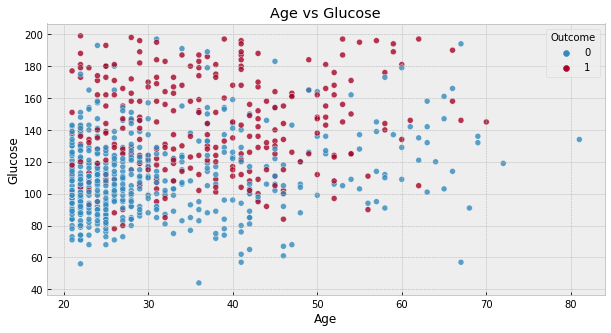

In [18]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=pima , x='Age' , y='Glucose' , hue='Outcome' , alpha=0.8)
plt.title('Age vs Glucose');

#### ความสัมพันธ์ระหว่างคุณสมบัติ คนที่ไม่เป็นเบาหวาน(0) และ คนที่เป็นเบาหวาน(1)

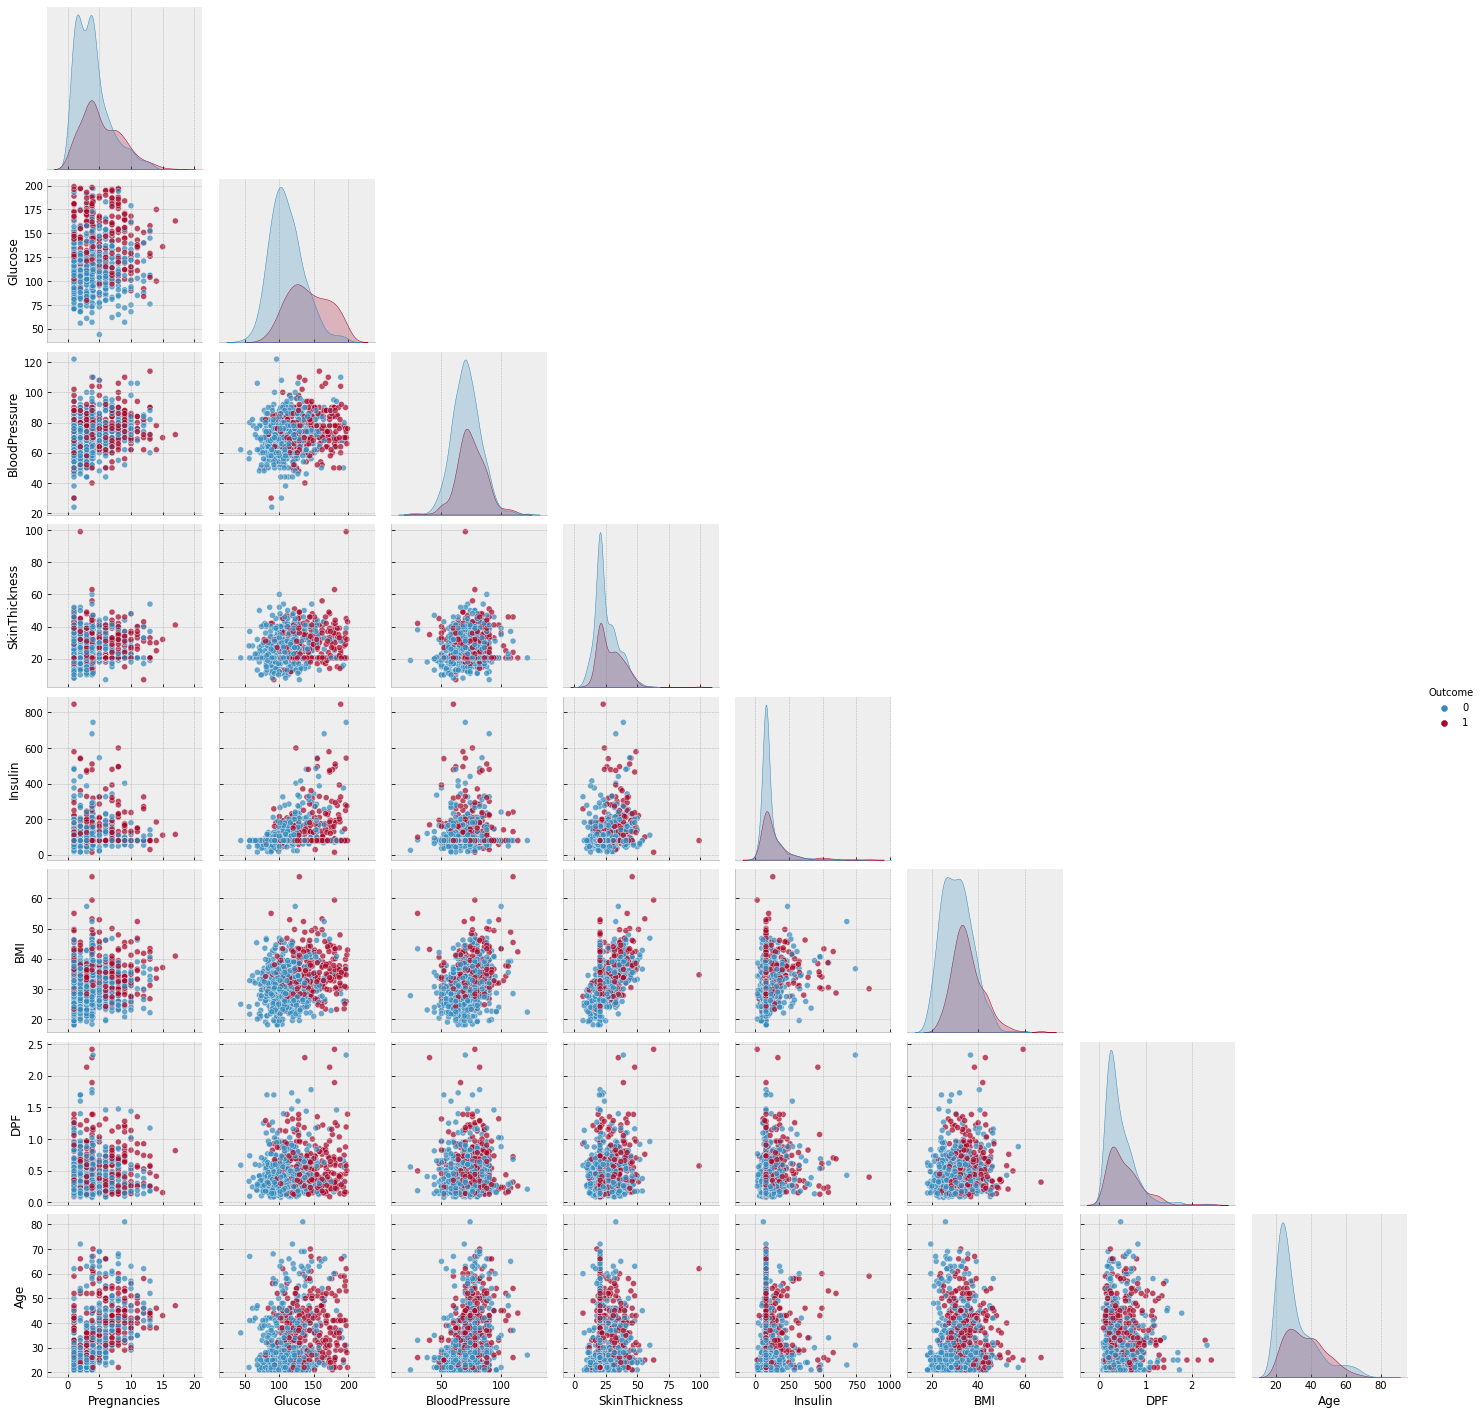

In [19]:
sns.pairplot(pima , hue='Outcome' , corner=True ,plot_kws={'alpha': 0.7});

## Data Preparation

In [20]:
data = pima.copy()
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6.000000,148.0,72.0,35.000000,79.799479,33.6,0.627,50,1
1,1.000000,85.0,66.0,29.000000,79.799479,26.6,0.351,31,0
2,8.000000,183.0,64.0,20.536458,79.799479,23.3,0.672,32,1
3,1.000000,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,3.845052,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1


In [21]:
feature = data.drop('Outcome' , axis=1)
target = data['Outcome']

In [22]:
feature.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age
0,6.000000,148.0,72.0,35.000000,79.799479,33.6,0.627,50
1,1.000000,85.0,66.0,29.000000,79.799479,26.6,0.351,31
2,8.000000,183.0,64.0,20.536458,79.799479,23.3,0.672,32
3,1.000000,89.0,66.0,23.000000,94.000000,28.1,0.167,21
4,3.845052,137.0,40.0,35.000000,168.000000,43.1,2.288,33


#### แบ่งข้อมูลออก 3 ชุด ชุดฝึก ชุดตรวจสอบ ชุดทดสอบ

In [23]:
x_train , x_val , y_train , y_val = train_test_split(feature , target , train_size=0.7 , random_state=50)
x_val , x_test , y_val , y_test = train_test_split(x_val , y_val , train_size=0.5 , random_state=50)

In [24]:
x_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age
465,3.845052,124.0,56.0,13.000000,105.000000,21.8,0.452,21
595,3.845052,188.0,82.0,14.000000,185.000000,32.0,0.682,22
24,11.000000,143.0,94.0,33.000000,146.000000,36.6,0.254,51
424,8.000000,151.0,78.0,32.000000,210.000000,42.9,0.516,36
729,2.000000,92.0,52.0,20.536458,79.799479,30.1,0.141,22


In [25]:
print('Training data set = ',x_train.shape)
print('Validation data set = ',x_val.shape)
print('Testing data set = ',x_test.shape)


Training data set =  (537, 8)
Validation data set =  (115, 8)
Testing data set =  (116, 8)


## Model Selection

In [26]:
algor = [LogisticRegression() , RandomForestClassifier() , KNeighborsClassifier() , 
         SVC() , GaussianNB() , AdaBoostClassifier()]

In [27]:
def model_select(model) :
    pipe = Pipeline([
        ('scaler' , StandardScaler()) , 
        ('model' , model)
    ])
    
    pipe.fit(x_train , y_train)
    y_pred = pipe.predict(x_val)
    print(model)
    print('\n')
    print(classification_report(y_pred , y_val))
    print(confusion_matrix(y_pred , y_val))
    print('-'*100)


In [28]:
for model in algor :
    model_select(model)
    

LogisticRegression()


              precision    recall  f1-score   support

           0       0.88      0.76      0.82        88
           1       0.46      0.67      0.55        27

    accuracy                           0.74       115
   macro avg       0.67      0.71      0.68       115
weighted avg       0.78      0.74      0.75       115

[[67 21]
 [ 9 18]]
----------------------------------------------------------------------------------------------------
RandomForestClassifier()


              precision    recall  f1-score   support

           0       0.89      0.79      0.84        86
           1       0.54      0.72      0.62        29

    accuracy                           0.77       115
   macro avg       0.72      0.76      0.73       115
weighted avg       0.80      0.77      0.78       115

[[68 18]
 [ 8 21]]
----------------------------------------------------------------------------------------------------
KNeighborsClassifier()


              precision    reca

#### จากการวัดผลเบื้องต้น Random Forest Classifier ให้ผลลัพธ์ดีที่สุด

### Random Forest Classifier

In [29]:
model = RandomForestClassifier()

### Feature Selection

In [30]:
rfecv = RFECV(model , cv=5)

In [31]:
rfecv.fit(x_train , y_train)

RFECV(cv=5, estimator=RandomForestClassifier())

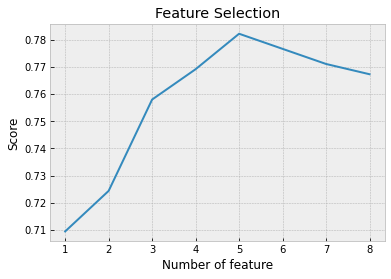

In [32]:
plt.plot(np.arange(1,len(x_train.columns)+1) , rfecv.grid_scores_)
plt.title('Feature Selection')
plt.xlabel('Number of feature')
plt.ylabel('Score');

#### จำนวน feature ที่เหมาะสม

In [33]:
print(rfecv.n_features_)

5


In [34]:
print(x_train.iloc[:,rfecv.support_].columns)

Index(['Pregnancies', 'Glucose', 'BMI', 'DPF', 'Age'], dtype='object')


In [35]:
model.fit(x_train , y_train)

RandomForestClassifier()

#### ความสำคัญของแต่ละ feature

Text(0.5, 1.0, 'Feature Importances')

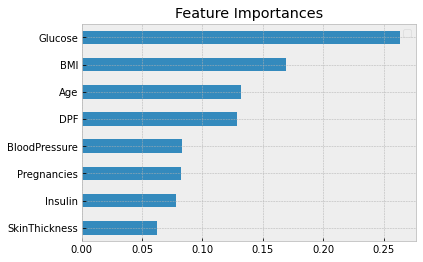

In [36]:
feat_select = pd.DataFrame(model.feature_importances_ , feature.columns).sort_values(0)
feat_select.plot(kind='barh')
plt.legend('')
plt.title('Feature Importances')

#### นำขั้นตอนทั้งหมด เข้าไปใน Pipelline 

In [37]:
pipe = Pipeline([
    ('feature_selection' , rfecv) ,
    ('scaler' , StandardScaler()) , 
    ('model' , model)
])

#### หา parameter ที่เหมาะสมที่สุดด้วย GridSearchCV

In [38]:
pipe_grid = GridSearchCV(pipe , param_grid=dict(model__n_estimators=[50,100,150] , 
                                               model__max_depth=[3,4,5] ,
                                               model__criterion=['gini', 'entropy']) , cv=5 , n_jobs=-1 , verbose=3)

In [39]:
pipe_grid.fit(x_train , y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_selection',
                                        RFECV(cv=5,
                                              estimator=RandomForestClassifier())),
                                       ('scaler', StandardScaler()),
                                       ('model', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [50, 100, 150]},
             verbose=3)

#### parameter ที่เหมาะสม

In [40]:
print(pipe_grid.best_params_)

{'model__criterion': 'gini', 'model__max_depth': 5, 'model__n_estimators': 150}


In [41]:
print(pipe_grid.best_score_)

0.7802872966424368


In [42]:
best_model = pipe_grid.best_estimator_

In [43]:
predict = best_model.predict(x_test)

## Model Evaluation

#### ขั้นตอนสุดท้าย วัดผลลัพธ์จากโมเดล

In [44]:
print(classification_report(predict , y_test))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82        84
           1       0.55      0.75      0.63        32

    accuracy                           0.76       116
   macro avg       0.72      0.76      0.73       116
weighted avg       0.79      0.76      0.77       116



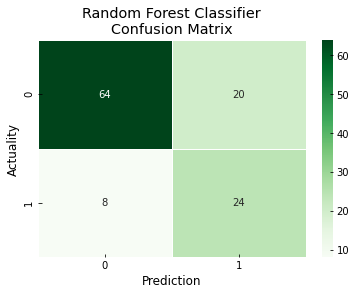

In [45]:
sns.heatmap(confusion_matrix(predict , y_test) , annot=True , fmt='.0f' , cmap='Greens' , linewidths=1)
plt.title('Random Forest Classifier\nConfusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actuality');

In [46]:
predict_prob = best_model.predict_proba(x_test)

In [47]:
tpr , fpr , ths = roc_curve(y_test , predict_prob[:,1])

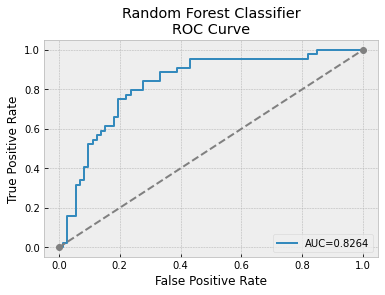

In [48]:
plt.plot(tpr , fpr , label=f'AUC={roc_auc_score(y_test , predict_prob[:,1]).round(4)}')
plt.plot([0,1] , [0,1] , 'o--' , color='0.5')
plt.title('Random Forest Classifier\nROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right');